In [1]:
from pyulog import *
from pyulog.px4 import *
from html import escape
import sqlite3
from IPython.core.display import display, HTML
import px4tools
from bs4 import BeautifulSoup as soup
from urllib.parse import urlparse, parse_qs
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# importing sys
import sys
 
# adding FlightReview module to the system path
sys.path.insert(0, './flight_review/app/plot_app')

from helper import *
from db_entry import *
from configured_plots import generate_plots
from plotted_tables import *
from config_tables import *

BULK_PROCESS = False

No module named 'mpl_toolkits.basemap'

    sudo apt-get install python-basemap
    or:
    conda install basemap

No module named 'mpl_toolkits.basemap'


In [2]:
# Helper methods

def read_ulg_data_as_df(file_name):
    data = None
    try:
        data = px4tools.read_ulog(file_name)
    except:
        None
    return data

def print_ulog_info(ulog):
    print('System: {:}'.format(ulog.msg_info_dict['sys_name']))
    if 'ver_hw' in ulog.msg_info_dict:
        print('Hardware: {:}'.format(ulog.msg_info_dict['ver_hw']))
    if 'ver_sw' in ulog.msg_info_dict:
        print('Software Version: {:}'.format(ulog.msg_info_dict['ver_sw']))
    # dropouts
    dropout_durations = [ dropout.duration for dropout in ulog.dropouts]
    if len(dropout_durations) > 0:
        total_duration = sum(dropout_durations) / 1000
        if total_duration > 5:
            total_duration_str = '{:.0f}'.format(total_duration)
        else:
            total_duration_str = '{:.2f}'.format(total_duration)
        print('Dropouts: {:} ({:} s)'.format(
            len(dropout_durations), total_duration_str))

    # logging duration
    m, s = divmod(int((ulog.last_timestamp - ulog.start_timestamp)/1e6), 60)
    h, m = divmod(m, 60)
    print('Logging duration: {:d}:{:02d}:{:02d}'.format( h, m, s))


In [3]:
# What the website actually plots
file_name = 'C:\\Users\\rwita\\Downloads\\dce0a1db-f7ad-43e3-9c58-1a49f3edd568.ulg'

ulog = ULog(file_name)
data = ulog.data_list
px4_ulog = PX4ULog(ulog)
px4_ulog.add_roll_pitch_yaw()
use_downsample = False
title = 'Flight Review - ' + px4_ulog.get_mav_type()

db_data = DBData()
vehicle_data = None

In [4]:
print("message names: {:}".format(sorted([d.name for d in data])))
print()
print_ulog_info(ulog)

message names: ['action_request', 'actuator_armed', 'actuator_controls_0', 'actuator_controls_1', 'actuator_controls_3', 'actuator_motors', 'actuator_outputs', 'actuator_servos', 'airspeed', 'airspeed_validated', 'airspeed_wind', 'airspeed_wind', 'battery_status', 'battery_status', 'commander_state', 'control_allocator_status', 'cpuload', 'differential_pressure', 'estimator_attitude', 'estimator_attitude', 'estimator_attitude', 'estimator_baro_bias', 'estimator_baro_bias', 'estimator_baro_bias', 'estimator_event_flags', 'estimator_event_flags', 'estimator_event_flags', 'estimator_global_position', 'estimator_global_position', 'estimator_global_position', 'estimator_gps_status', 'estimator_gps_status', 'estimator_gps_status', 'estimator_innovation_test_ratios', 'estimator_innovation_test_ratios', 'estimator_innovation_test_ratios', 'estimator_innovation_variances', 'estimator_innovation_variances', 'estimator_innovation_variances', 'estimator_innovations', 'estimator_innovations', 'esti

In [5]:
info = {}
if ulog is not None:
    px4_ulog = PX4ULog(ulog)
    info['type'] = px4_ulog.get_mav_type()
    airframe_name_tuple = get_airframe_name(ulog)
    if airframe_name_tuple is not None:
        airframe_name, airframe_id = airframe_name_tuple
        if len(airframe_name) == 0:
            info['airframe'] = airframe_id
        else:
            info['airframe'] = airframe_name
    sys_hardware = ''
    if 'ver_hw' in ulog.msg_info_dict:
        sys_hardware = escape(ulog.msg_info_dict['ver_hw'])
        info['hardware'] = sys_hardware
    if 'sys_uuid' in ulog.msg_info_dict and sys_hardware != 'SITL':
        info['uuid'] = escape(ulog.msg_info_dict['sys_uuid'])
    branch_info = ''
    if 'ver_sw_branch' in ulog.msg_info_dict:
        branch_info = ' (branch: '+ulog.msg_info_dict['ver_sw_branch']+')'
    if 'ver_sw' in ulog.msg_info_dict:
        ver_sw = escape(ulog.msg_info_dict['ver_sw'])
        info['software'] = ver_sw + branch_info
        
info

{'type': 'VTOL Standard',
 'airframe': 'Generic Standard VTOL, Standard VTOL',
 'hardware': 'PX4_FMU_V5',
 'uuid': '0002000000002037365837565012003b0034',
 'software': '46a12a09bf11c8cbafc5ad905996645b4fe1a9df'}

In [6]:
plots = generate_plots(ulog, px4_ulog, db_data, vehicle_data, "", "")

<class 'IndexError'> (vehicle_local_position_groundtruth): list index out of range
<class 'IndexError'> (position_setpoint_triplet): list index out of range
<class 'IndexError'> (vehicle_attitude_groundtruth): list index out of range
<class 'IndexError'> (vehicle_angular_velocity_groundtruth): list index out of range
<class 'IndexError'> (vehicle_attitude_groundtruth): list index out of range
<class 'IndexError'> (vehicle_angular_velocity_groundtruth): list index out of range
<class 'IndexError'> (vehicle_attitude_groundtruth): list index out of range
<class 'IndexError'> (vehicle_angular_velocity_groundtruth): list index out of range
<class 'KeyError'> (vehicle_global_position): 'vel_n'
<class 'IndexError'> (vehicle_imu_status): list index out of range
<class 'IndexError'> (fifo data): list index out of range
<class 'IndexError'> (fifo data): list index out of range
<class 'IndexError'> (distance_sensor): list index out of range


C:\Users\rwita\miniconda3\envs\tf_gpu\lib\site-packages\bokeh\models\plots.py:815: UserWarning: 
You are attempting to set `plot.legend.click_policy` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)


<class 'KeyError'> (vehicle_status): 'failsafe_and_user_took_over'
<class 'IndexError'> (failsafe_flags): list index out of range


In [7]:
tables = get_info_table_html(ulog, px4_ulog, db_data, vehicle_data, None)

In [8]:
display(HTML(tables[0]))

Airframe:,Generic Standard VTOLStandard VTOL (13000)
Hardware:,PX4_FMU_V5 (V550)
Software Version:,v1.13.2 (46a12a09)
OS Version:,"NuttX, v11.0.0"
Estimator:,EKF2
"Logging Start Log timezone: 03-02-2023 05:49 SDLOG_UTC_OFFSET: 0"" class=""fa fa-question"" aria-hidden=""true"" style=""font-size: larger; color:#666"">:",03-02-2023 05:49
Logging Duration:,0:03:50
Vehicle LifeFlight Time:,3 hours 51 minutes 15 seconds
Vehicle UUID:,0002000000002037365837565012003b0034
Distance:,1.62 km
Max Altitude Difference:,107 m


In [9]:
data = read_ulg_data_as_df(file_name)
messages = data.keys()
rc_messages = list(filter(lambda key: "input_rc" in key, messages))

In [10]:
list(messages)

['t_action_request_0',
 't_actuator_armed_0',
 't_actuator_controls_0_0',
 't_actuator_controls_1_0',
 't_actuator_controls_3_0',
 't_actuator_motors_0',
 't_actuator_outputs_2',
 't_actuator_servos_0',
 't_airspeed_0',
 't_airspeed_validated_0',
 't_airspeed_wind_0',
 't_airspeed_wind_1',
 't_battery_status_0',
 't_battery_status_1',
 't_commander_state_0',
 't_control_allocator_status_0',
 't_cpuload_0',
 't_differential_pressure_0',
 't_estimator_attitude_0',
 't_estimator_attitude_1',
 't_estimator_attitude_2',
 't_estimator_baro_bias_0',
 't_estimator_baro_bias_1',
 't_estimator_baro_bias_2',
 't_estimator_event_flags_0',
 't_estimator_event_flags_1',
 't_estimator_event_flags_2',
 't_estimator_global_position_0',
 't_estimator_global_position_1',
 't_estimator_global_position_2',
 't_estimator_gps_status_0',
 't_estimator_gps_status_1',
 't_estimator_gps_status_2',
 't_estimator_innovation_test_ratios_0',
 't_estimator_innovation_test_ratios_1',
 't_estimator_innovation_test_rati

In [11]:
data['t_manual_control_switches_0']

,timestamp,f_timestamp_sample,f_switch_changes,f_mode_slot,f_arm_switch,f_return_switch,f_loiter_switch,f_offboard_switch,f_kill_switch,f_gear_switch,f_transition_switch,f_photo_switch,f_video_switch
timestamp,,,,,,,,,,,,,
0 days 00:08:33.673150,513673150,513652146,15,1,0,0,0,0,3,0,3,0,0
0 days 00:08:34.676560,514676560,514655498,15,1,0,0,0,0,3,0,3,0,0
0 days 00:08:35.689868,515689868,515668845,15,1,0,0,0,0,3,0,3,0,0
0 days 00:08:36.708193,516708193,516687210,15,1,0,0,0,0,3,0,3,0,0
0 days 00:08:37.719048,517719048,517695861,15,1,0,0,0,0,3,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:12:20.231898,740231898,740203365,19,6,0,0,0,0,3,0,3,0,0
0 days 00:12:20.834915,740834915,740811479,20,6,0,0,0,0,1,0,3,0,0
0 days 00:12:21.850801,741850801,741829773,20,6,0,0,0,0,1,0,3,0,0


In [12]:
# test.msg_info_dict
# test.msg_info_multiple_dict
# test.initial_parameters
# test.logged_messages
# get_total_flight_time(ulog)

In [13]:
# Gathering one row worth of data
def get_row_of_data(log_link, ulog):
    row_data = {}
    row_data['link'] = log_link
    
    px4_ulog = PX4ULog(ulog)
        
    # GPS Present
    try:        
        gps_data = ulog.get_dataset('vehicle_gps_position')
        row_data['gps_data'] = "Yes"
    except:
        row_data['gps_data'] = "No"
        
    # Airframe
    row_data['airframe_type'] = px4_ulog.get_mav_type()
    row_data['airframe_name'] = get_airframe_name(ulog)[0]
    
    # Hardware
    row_data['hardware'] = ulog.msg_info_dict['ver_hw']
    
    # Software
    branch_info = ''
    if 'ver_sw_branch' in ulog.msg_info_dict:
        branch_info = ' (branch: ' + ulog.msg_info_dict['ver_sw_branch']+')'
    if 'ver_sw' in ulog.msg_info_dict:
        ver_sw = escape(ulog.msg_info_dict['ver_sw'])
        row_data['software'] = ver_sw + branch_info
        
    # Flight Duration        
    m, s = divmod(int((ulog.last_timestamp - ulog.start_timestamp)/1e6), 60)
    h, m = divmod(m, 60)
    row_data['flight_duration'] = '{:d}:{:02d}:{:02d}'.format(h, m, s)
    
    # Logging Start Time
    try:
        # get the first non-zero timestamp
        gps_data = ulog.get_dataset('vehicle_gps_position')
        indices = np.nonzero(gps_data.data['time_utc_usec'])
        if len(indices[0]) > 0:
            # we use the timestamp from the log and then convert it with JS to
            # display with local timezone.
            # In addition we add a tooltip to show the timezone from the log
            logging_start_time = int(gps_data.data['time_utc_usec'][indices[0][0]] / 1000000)

            utc_offset_min = ulog.initial_parameters.get('SDLOG_UTC_OFFSET', 0)
            utctimestamp = datetime.datetime.utcfromtimestamp(
                logging_start_time+utc_offset_min*60).replace(tzinfo=datetime.timezone.utc)

            row_data['start_time'] = str(utctimestamp.strftime('%d-%m-%Y %H:%M'))
    except:
        # Ignore. Eg. if topic not found
        pass
        
    # Flight Modes
    flight_mode_changes = get_flight_mode_changes(ulog)
    flight_mode_changes = filter(lambda elem: elem[1] != -1, flight_mode_changes)
    flight_mode_names = map(lambda elem: flight_modes_table[elem[1]][0], flight_mode_changes)
    row_data['flight_modes'] = list(set(flight_mode_names))
        
    # Altitude Information
    local_pos = ulog.get_dataset('vehicle_local_position')
    pos_z = local_pos.data['z']
    row_data['altitude_min'] = np.amin(pos_z)
    row_data['altitude_max'] = np.amax(pos_z)
    row_data['altitude_avg'] = np.mean(pos_z)
    
    # Parameters
    row_data['parameters'] = ulog.initial_parameters
    
    # Terrain Following
    if row_data['parameters']['MPC_ALT_MODE'] in [1, 2]:
        row_data['terrain_following'] = "Yes"
    else:
        row_data['terrain_following'] = "No"
        
    # Terrain Following
    if row_data['parameters']['COM_OBS_AVOID'] == 1:
        row_data['object_avoidance'] = "Yes"
    else:
        row_data['object_avoidance'] = "No"
    
    # Stuff that I did not find
    row_data['upload_date'] = ""
    row_data['description'] = ""
    row_data['gyroscope'] = ""
    row_data['mag_accel'] = ""
    row_data['barometer'] = ""
    row_data['compass'] = ""
    row_data['rating'] = ""
    row_data['error'] = ""
    row_data['soft_release_date'] = ""
    row_data['remote_control'] = ""
    row_data['waypoints'] = ""
    
    # Returning one row of data
    return row_data


# get_row_of_data("link", ulog)

In [14]:
# Reading logs and extracting fields
if BULK_PROCESS:
    f = open('E:\\Purdue\\Spring 2023\\CS 590\\Work\\GitHub Issue Scraper\\scrape_data\\px4_log_links.json')
    data = json.load(f)
    results = []
    failed = []

    for key, value in tqdm(data.items()):
        parsed_issue_link = urlparse(key)
        issue_id = parsed_issue_link.path.split("/")[-1]
        if value['count'] > 0:
            for log_link in value['log_links']:
                parsed_log_link = urlparse(log_link)
                log_id = parse_qs(parsed_log_link.query)
                if 'log' in log_id:
                    log_id = parse_qs(parsed_log_link.query)['log'][0]
                    log_file_path = f"E:\\Purdue\\Spring 2023\\CS 590\\Work\\GitHub Issue Scraper\\Logs\\{issue_id}\\{log_id}.ulg"
                    if os.path.isfile(log_file_path):
                        try:
                            ulog = load_ulog_file(log_file_path)
                            results.append(get_row_of_data(log_link, ulog))
                        except:
                            failed.append(log_file_path)

    print(f"{len(results)} processed, {len(failed)} failed")

    df = pd.DataFrame.from_dict(results)
    new_df = df[['link', 'upload_date', 'gps_data', 'description', 'airframe_type', 'airframe_name', 'hardware', 'gyroscope',
           'mag_accel', 'barometer', 'compass', 'software', 'flight_duration', 'start_time', 'rating', 'error',
           'flight_modes', 'soft_release_date', 'remote_control', 'altitude_min', 'altitude_avg', 'altitude_max', 'waypoints', 'terrain_following',
           'object_avoidance', 'parameters']]
    new_df.to_excel("./parsed_df.xlsx")

In [15]:
# # New
ulog.get_dataset('manual_control_switches')

# # Old
# ulog.get_dataset('manual_control_setpoint')

# Older
# ulog.get_dataset('rc_channels')

In [16]:
df = pd.DataFrame(ulog.get_dataset('manual_control_setpoint').data)
df = df[['y', 'x', 'r', 'z', 'aux1', 'aux2']]
rc_used = False
for (i, value) in df.std().items():
    if value != 0:
        rc_used = True
        break
rc_used

True

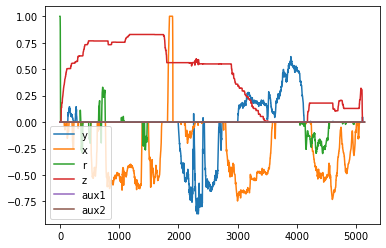

In [17]:
df.plot()
plt.show()

In [18]:
df_data = ulog.get_dataset('manual_control_switches').data
df = pd.DataFrame(df_data)
df = df[['mode_slot', 'kill_switch']]
df['kill_switch'] = df['kill_switch'] == 1
flight_modes = list(df['mode_slot'].unique())
kill_switch_engaged = True in df['kill_switch'].unique()
print(f"Flight Modes: {flight_modes}")
print(f"Killswitch Engaged: {kill_switch_engaged}")

Flight Modes: [1, 4, 6]
Killswitch Engaged: True


In [ ]:
px4_ulog.get_configured_rc_input_names(-1)

In [44]:
ulog = load_ulog_file("7fa41e74-e051-4624-a891-97f72d663e55.ulg")
px4_ulog = PX4ULog(ulog)
df_data = ulog.get_dataset('rc_channels').data
df = pd.DataFrame(df_data)

num_rc_channels = min(8, np.amax(df_data['channel_count']))
channel_cols = ['channels['+str(i)+']' for i in range(num_rc_channels)]
channel_names = [px4_ulog.get_configured_rc_input_names(i) for i in range(num_rc_channels)]
df = df[channel_cols]

rc_used = False
for (i, value) in df.std().items():
    if value != 0:
        rc_used = True
        break
rc_used

True

In [42]:
df[['channels['+str(i)+']' for i in range(num_rc_channels)]]

,channels[0],channels[1],channels[2],channels[3],channels[4],channels[5],channels[6],channels[7]
0,0.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,-1.0
1,0.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,-1.0
2,0.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,-1.0
3,0.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,-1.0
4,0.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...
9014,0.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,1.0
9015,0.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,1.0
9016,0.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,1.0
9017,0.0,-0.0,-0.0,0.0,0.0,0.0,-1.0,1.0
